In [38]:
import numpy as np

from catenets.models.torch import TARNet, SNet
from econml.metalearners import SLearner, XLearner
from econml.dr import LinearDRLearner
from econml.dml import CausalForestDML
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_percentage_error

import torch
import pytorch_lightning as pl

import matplotlib.pyplot as plt

# Create data

In [2]:
SAMPLE_SIZE = 5_000
TRAIN_SIZE = 4_500
N_FEATURES = 20

X = np.random.normal(0, 1, (SAMPLE_SIZE, N_FEATURES))
T = np.random.binomial(1, .5, SAMPLE_SIZE)
weights = np.random.gumbel(5, 10, (SAMPLE_SIZE, N_FEATURES-1))

y = (50 * T * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)
y0 = (50 * 0 * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)
y1 = (50 * 1 * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)
effect_true = y1[TRAIN_SIZE:] - y0[TRAIN_SIZE:]

In [12]:
device = torch.device('mps')

In [15]:
SEED = 18
pl.seed_everything(SEED)

benchmark_models = {
    "SLearner": SLearner(overall_model=LGBMRegressor()),
    "XLearner": XLearner(models=LGBMRegressor()),
    "DRLearner": LinearDRLearner(),
    "CausalForestDML": CausalForestDML()
}

benchmark_results = {}
for model_name, model in benchmark_models.items():
    model.fit(
        X=X[:TRAIN_SIZE, :],
        T=T[:TRAIN_SIZE],
        Y=y[:TRAIN_SIZE]
    )
    effect_pred = model.effect(X[TRAIN_SIZE:])
    benchmark_results[model_name] = effect_pred

Global seed set to 18


In [17]:
tarnet = TARNet(
    n_unit_in=X.shape[1],
    binary_y=False,
    n_units_out_prop=32,
    n_units_r=8,
    nonlin="selu"
)
tarnet.fit(
    X=X[:TRAIN_SIZE,:],
    y=y[:TRAIN_SIZE],
    w=T[:TRAIN_SIZE]
)

TARNet(
  (_repr_estimator): RepresentationNet(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=8, bias=True)
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
      (3): Linear(in_features=8, out_features=8, bias=True)
      (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SELU()
      (6): Linear(in_features=8, out_features=8, bias=True)
      (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SELU()
    )
  )
  (_propensity_estimator): PropensityNet(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
      (3): Linear(in_features=32, out_features=2, bias=True)
      (4): Softmax(dim=-1)
    )
  )
)

In [20]:
effect_pred_tarnet = tarnet.predict(X=X[TRAIN_SIZE:, :]).detach().numpy()

In [30]:
snet = SNet(
    n_unit_in=X.shape[1],
    binary_y=False,
    n_units_out_prop=32,
    n_units_r=8,
    nonlin="selu"
)
snet.fit(
    X=X[:TRAIN_SIZE,:],
    y=y[:TRAIN_SIZE],
    w=T[:TRAIN_SIZE]
)

SNet(
  (_reps_mu0): RepresentationNet(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SELU()
      (6): Linear(in_features=50, out_features=50, bias=True)
      (7): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SELU()
    )
  )
  (_reps_mu1): RepresentationNet(
    (model): Sequential(
      (0): Linear(in_features=20, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SELU()
      (3): Linear(in_features=50, out_features=50, bias=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SELU()
      (6): 

In [28]:
effect_pred_snet = snet.predict(X=X[TRAIN_SIZE:, : ]).detach().numpy()

In [36]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

In [40]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

SLearner = 36.35605280117762


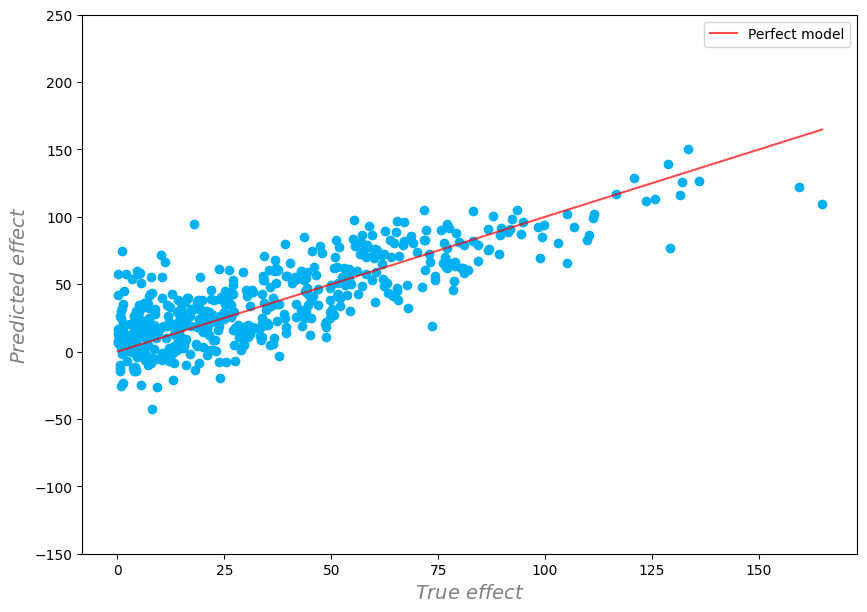

XLearner = 38.84673734114526


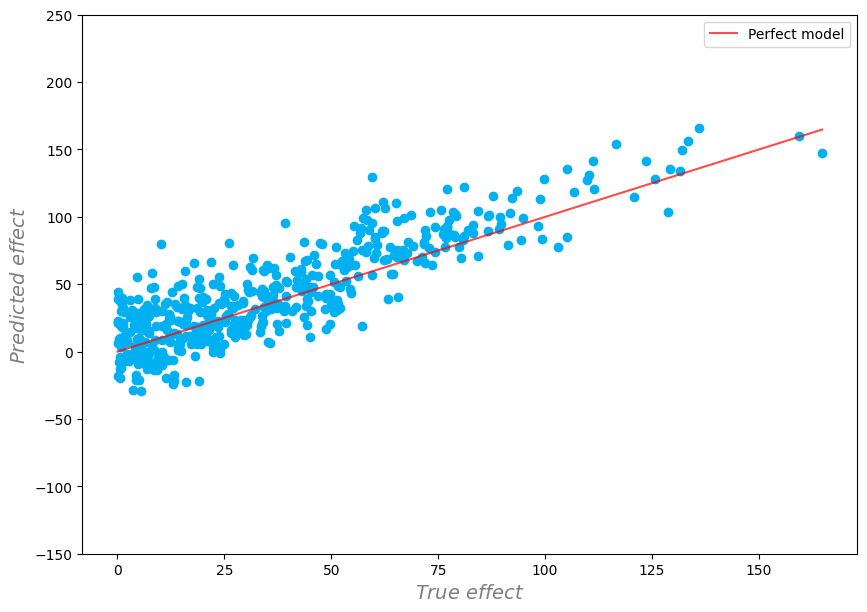

DRLearner = 46.44588912413491


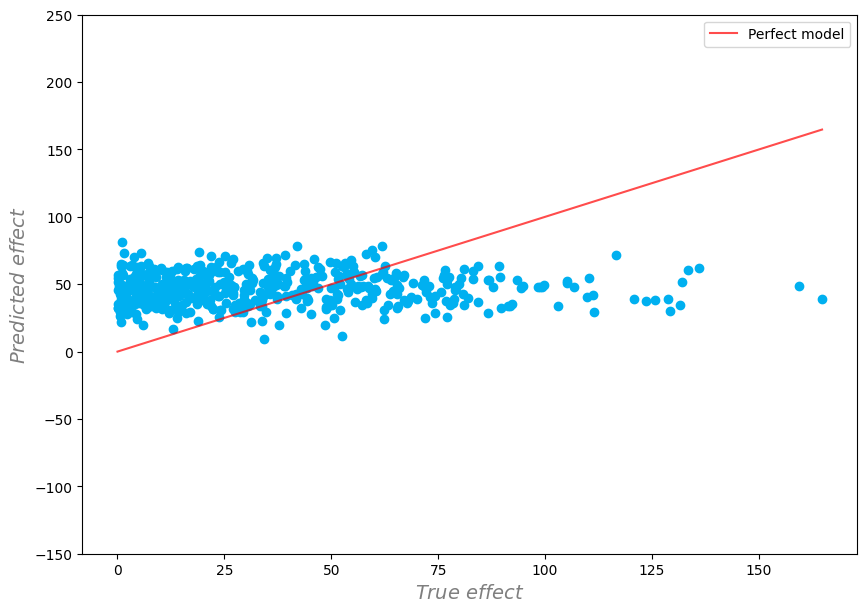

CausalForestDML = 20.62084290807047


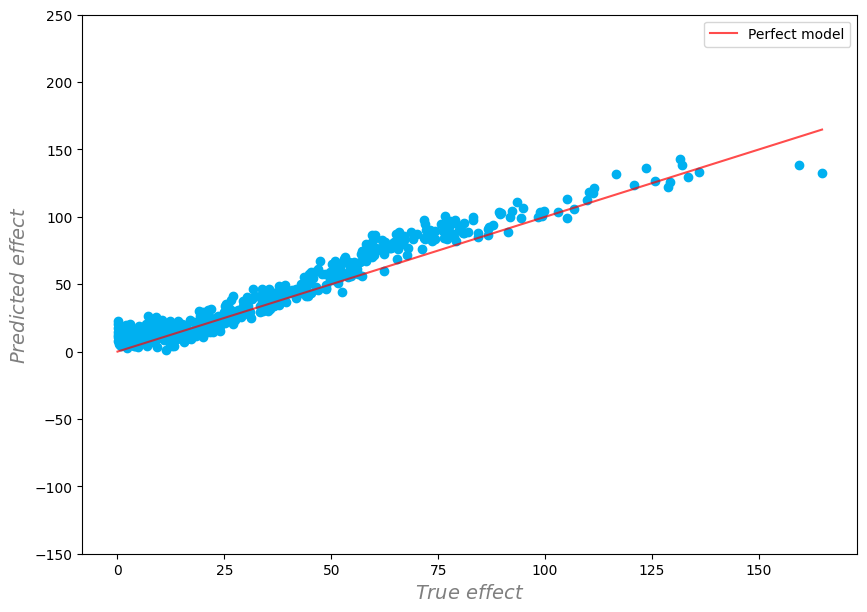

In [42]:
for model_name in benchmark_results.keys():
    effect_pred = benchmark_results[model_name]
    print(f"{model_name} = {mean_absolute_percentage_error(effect_true, effect_pred)}")

    plot_effect(effect_true=effect_true, effect_pred=effect_pred, ylim=(-150, 250))

21.565154024875095


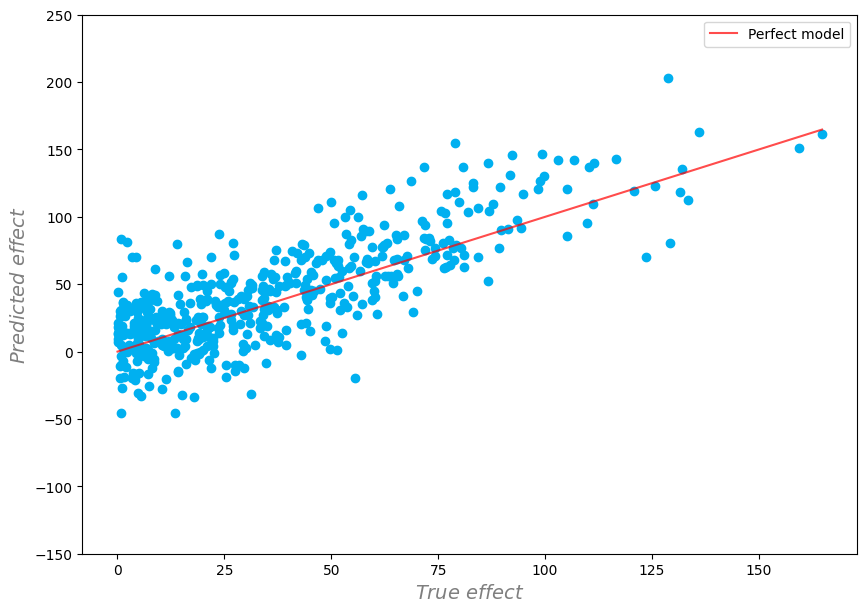

34.96320446458045


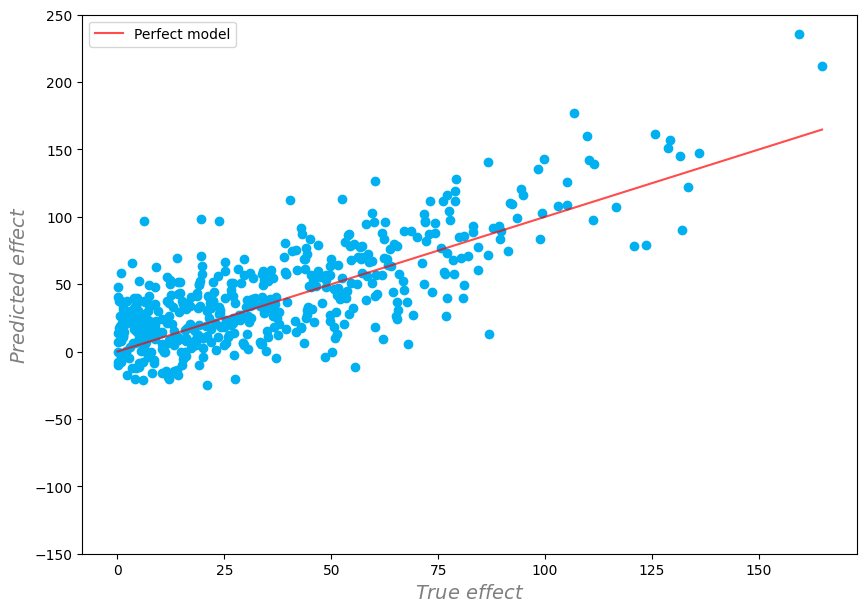

In [44]:
for f in [effect_pred_tarnet, effect_pred_snet]:
    print(mean_absolute_percentage_error(effect_true, f))
    plot_effect(effect_true=effect_true, effect_pred=f, ylim=(-150, 250))